# Leakage Simulation and Detection

## Initialize EPANET Python Toolkit (EPyT)

### You should always begin with this command to import the toolkit.

In [1]:
from epyt import epanet

### How pressure changes during large leakages and fire-fighting


![Alt text](images/img1.png)

![Alt text](images/img2.png)


When flow is increased within the network, e.g., due to fire-fighting, the pressure changes near that location. Investigate this change, at node '32'.

In [2]:
G = epanet('Net1.inp')

EPANET version 20200 loaded (EPyT version 1.1.6).
Input File Net1.inp loaded successfully.



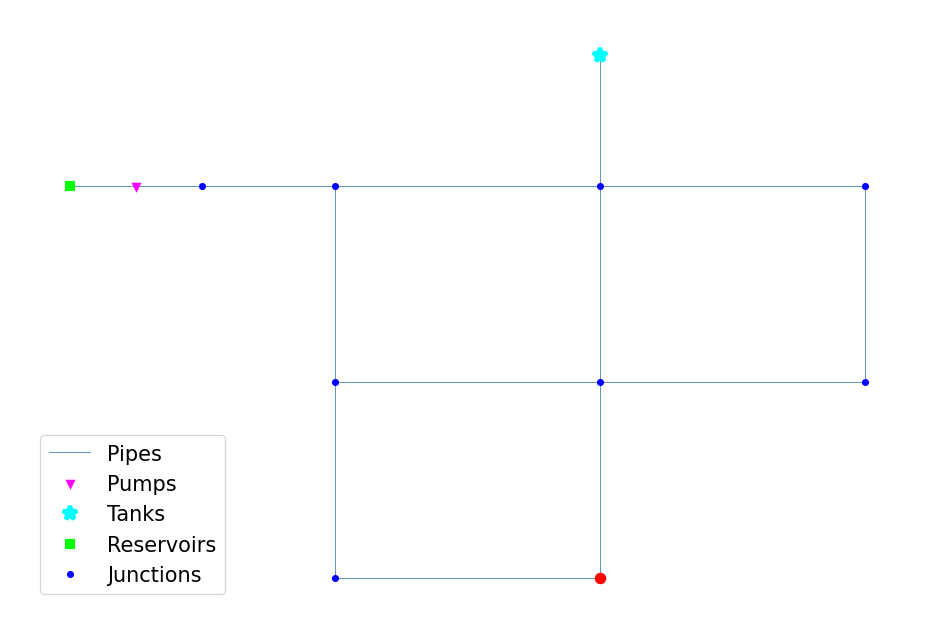

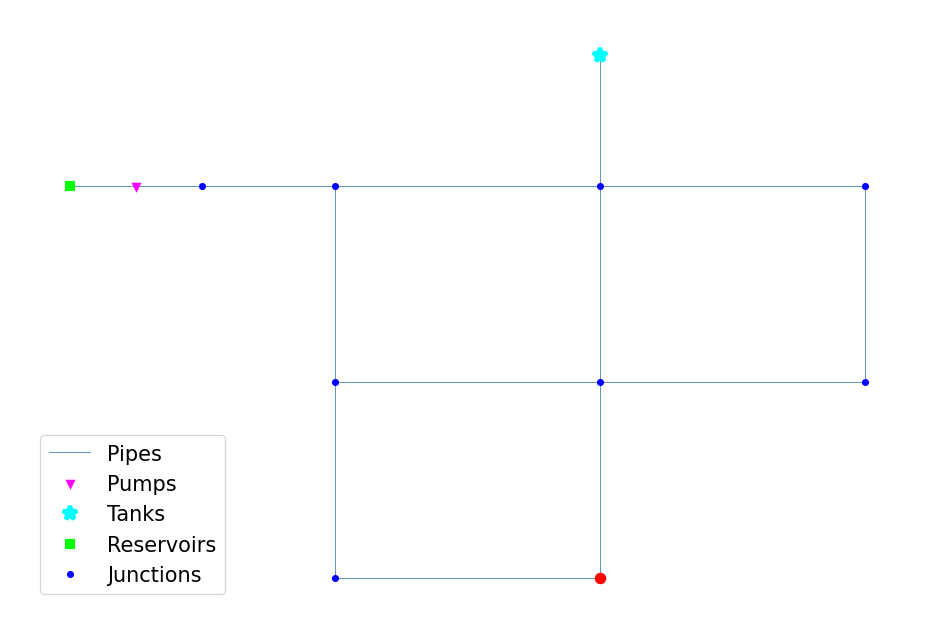

In [3]:
nodeID = '32'
G.plot(highlightnode=nodeID)

#### During fire-fighting, the base demand may increase up to x5. Will there be sufficient pressure?

In [4]:
idx = G.getNodeIndex(nodeID)
print("idx = ", idx)

idx =  9


In [5]:
bd = G.getNodeBaseDemands(idx)[1]
print("bd = ", bd)

bd =  [100.]


In [6]:
demand_multi = 8 # demand multiplicator
print("demand_multi = ", demand_multi)

demand_multi =  8


In [7]:
import numpy as np

d32 = bd * np.arange(1, demand_multi + 1) # create the different threads
print("d32 = ", d32)

d32 =  [100. 200. 300. 400. 500. 600. 700. 800.]


In [8]:
p32min = np.zeros(len(d32)) # initialize variable

for i, demand_value in enumerate(d32):
    G.setNodeBaseDemands(idx, demand_value)
    p32 = G.getComputedHydraulicTimeSeries().Pressure[:, idx-1]
    p32min[i] = np.min(p32)

C:\Users\Leontios\PycharmProjects\LeakageSimulationAndDetection\.venv\Lib\site-packages\epyt\epanet.py:13948: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())
C:\Users\Leontios\PycharmProjects\LeakageSimulationAndDetection\.venv\Lib\site-packages\epyt\epanet.py:13948: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())
C:\Users\Leontios\PycharmProjects\LeakageSimulationAndDetection\.venv\Lib\site-packages\epyt\epanet.py:13948: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())
C:\Users\Leontios\PycharmProjects\LeakageSimulationAndDetection\.venv\Lib\site-packages\epyt\epanet.py:13948: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())
C:\Users\Leontios\PycharmProjects\LeakageSimulationAndDetection\.venv\Lib\site-packages\epyt\epanet.py:13948: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.v

#### Plot demand vs pressure

Text(0, 0.5, 'Pressure (psi)')

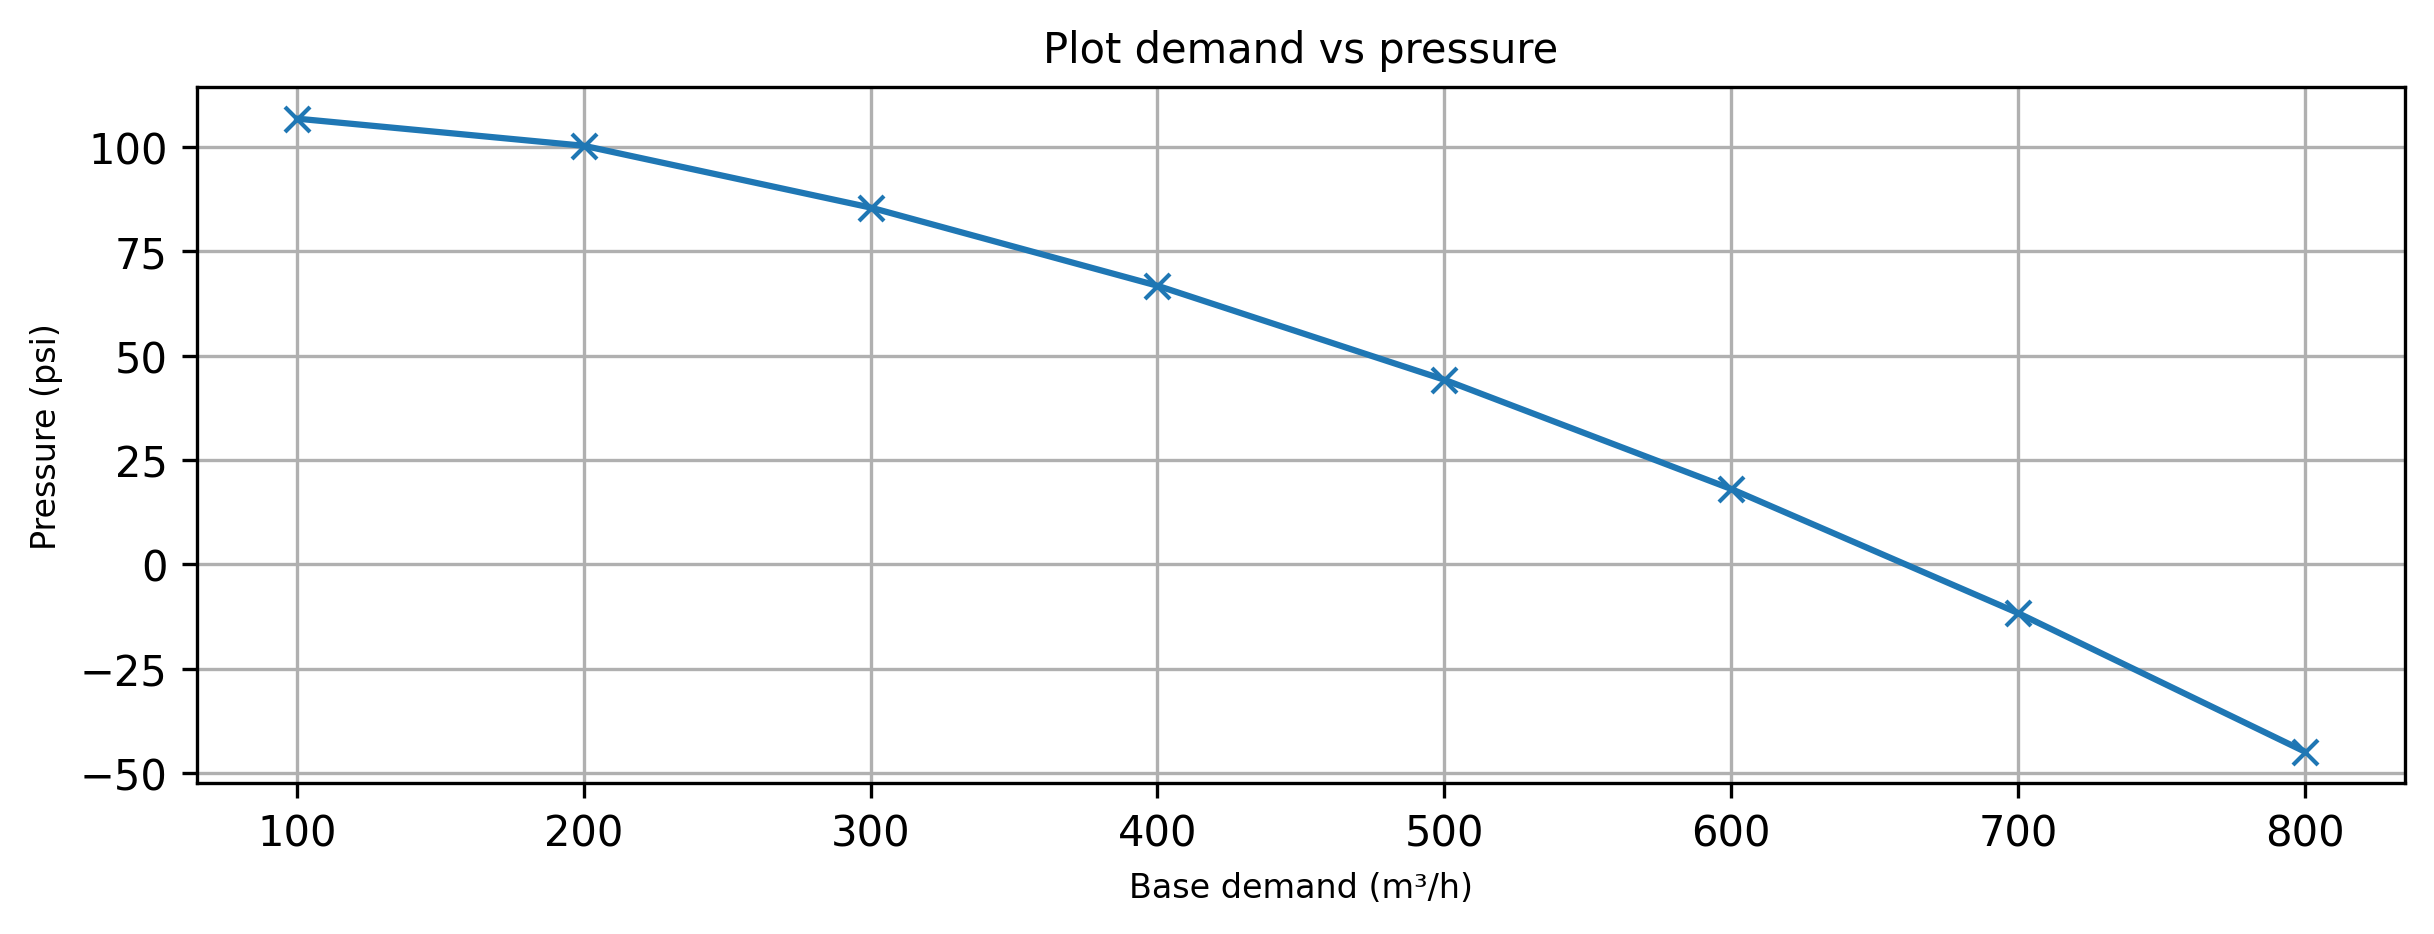

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 3))

fig.set_figwidth(8)
ax.plot(d32, p32min, 'x-')
ax.grid(True)
ax.set_title("Plot demand vs pressure", fontsize=10)
ax.set_xlabel(f"Base demand (m\u00B3/h)", fontsize=8)
ax.set_ylabel("Pressure (psi)", fontsize=8)

How about those negative pressures?

## Pressure Driven Simulations

When the pressure is low, it should approximate zero. This is not the default mode of operation in EPANET. However, it's easy to set it up:

In [10]:
type = 'PDA'
pmin = 0
preq = 0.1
pexp = 0.5
G.setDemandModel(type, pmin, preq, pexp)

Let's try this again

In [11]:
demand_multi = 10 # demand multiplicator
print("demand_multi = ", demand_multi)

demand_multi =  10


In [12]:
d32 = bd * np.arange(1, demand_multi + 1) # create the different threads
print("d32 = ", d32)

d32 =  [ 100.  200.  300.  400.  500.  600.  700.  800.  900. 1000.]


Text(0, 0.5, 'Pressure (psi)')

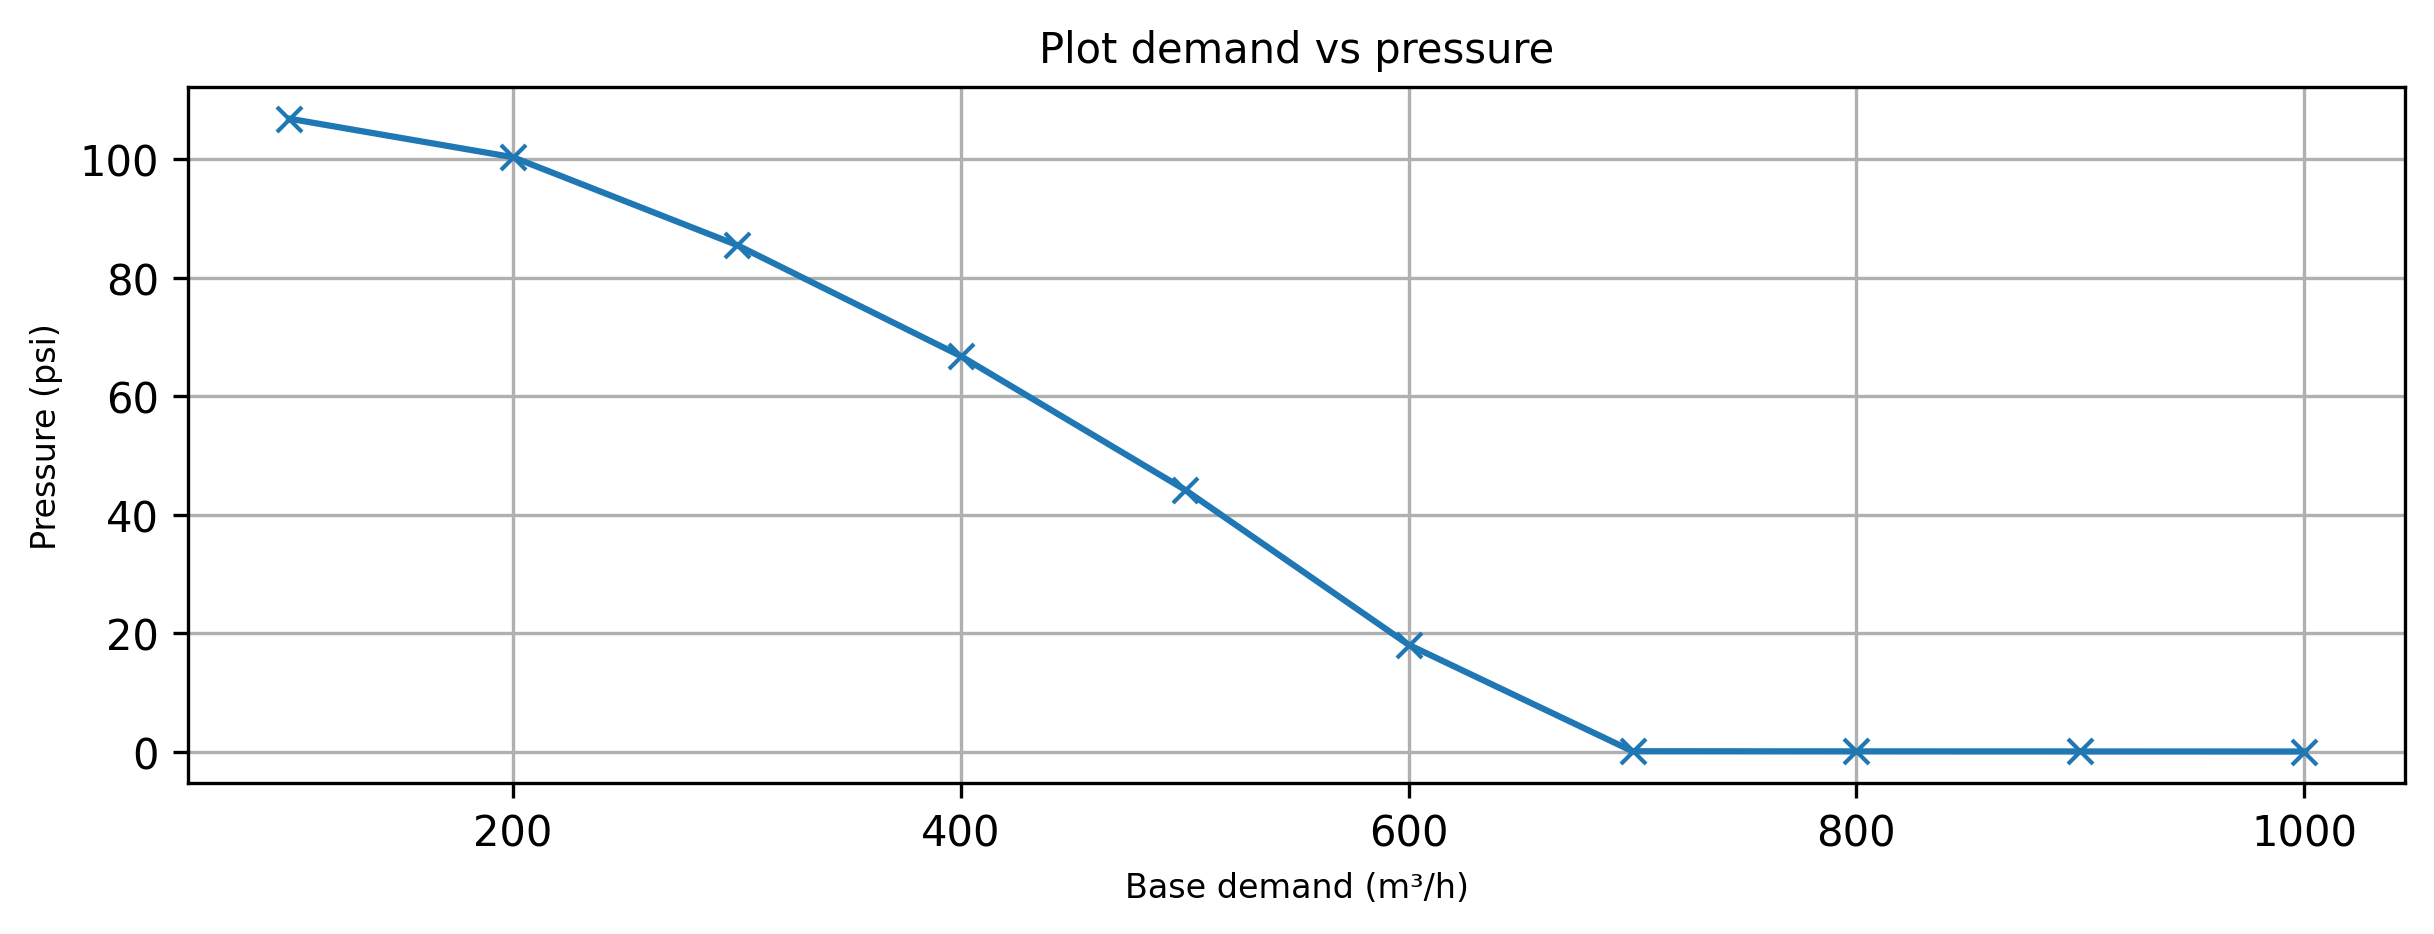

In [13]:
p32min = np.zeros(len(d32)) # initialize variable

for i, demand_value in enumerate(d32):
    G.setNodeBaseDemands(idx, demand_value)
    p32 = G.getComputedHydraulicTimeSeries().Pressure[:, idx-1]
    p32min[i] = np.min(p32)
fig, ax = plt.subplots(figsize=(4, 3))

fig.set_figwidth(8)
ax.plot(d32, p32min, 'x-')
ax.grid(True)
ax.set_title("Plot demand vs pressure", fontsize=10)
ax.set_xlabel(f"Base demand (m\u00B3/h)", fontsize=8)
ax.set_ylabel("Pressure (psi)", fontsize=8)

In [14]:
G.unload()

Close toolkit for the input file "Net1". EPANET Toolkit is unloaded.



## Leakage Simulations
#### Load network

In [15]:
d=epanet('Hanoi_pat.inp')

EPANET version 20200 loaded (EPyT version 1.1.6).
Input File Hanoi_pat.inp loaded successfully.



In [16]:
d.setTimeSimulationDuration(7*24*60*60)
d.setTimeHydraulicStep(300)

Simulate without leak

In [17]:
sim_leak_free = d.getComputedHydraulicTimeSeries()

Get inflow without leak and create measurements by inserting random noise

In [18]:
res_ind = d.getNodeReservoirIndex()
res_link = [np.where(d.NodesConnectingLinksIndex[:, 0] == res_ind[i])[0][0] for i in range(len(res_ind))]

Inflow1 = sim_leak_free.Flow[:, res_link] # inflow
eta = np.random.rand(len(Inflow1),1) * np.mean(Inflow1) * 0.0001
y1 = Inflow1 * (1 + eta) # measured inflow

#### Simulate leakage

In [19]:
leak_node = 10
leak_emit = 20  # random leak emitter coefficient [2 20]
emit = d.getNodeEmitterCoeff()
emit = np.zeros_like(emit)
emit[leak_node-1] = leak_emit  # set emitter coefficient (leakage) value
d.setNodeEmitterCoeff(emit)
sim_leak = d.getComputedHydraulicTimeSeries()

Get inflow with leak and create measurements by inserting random noise

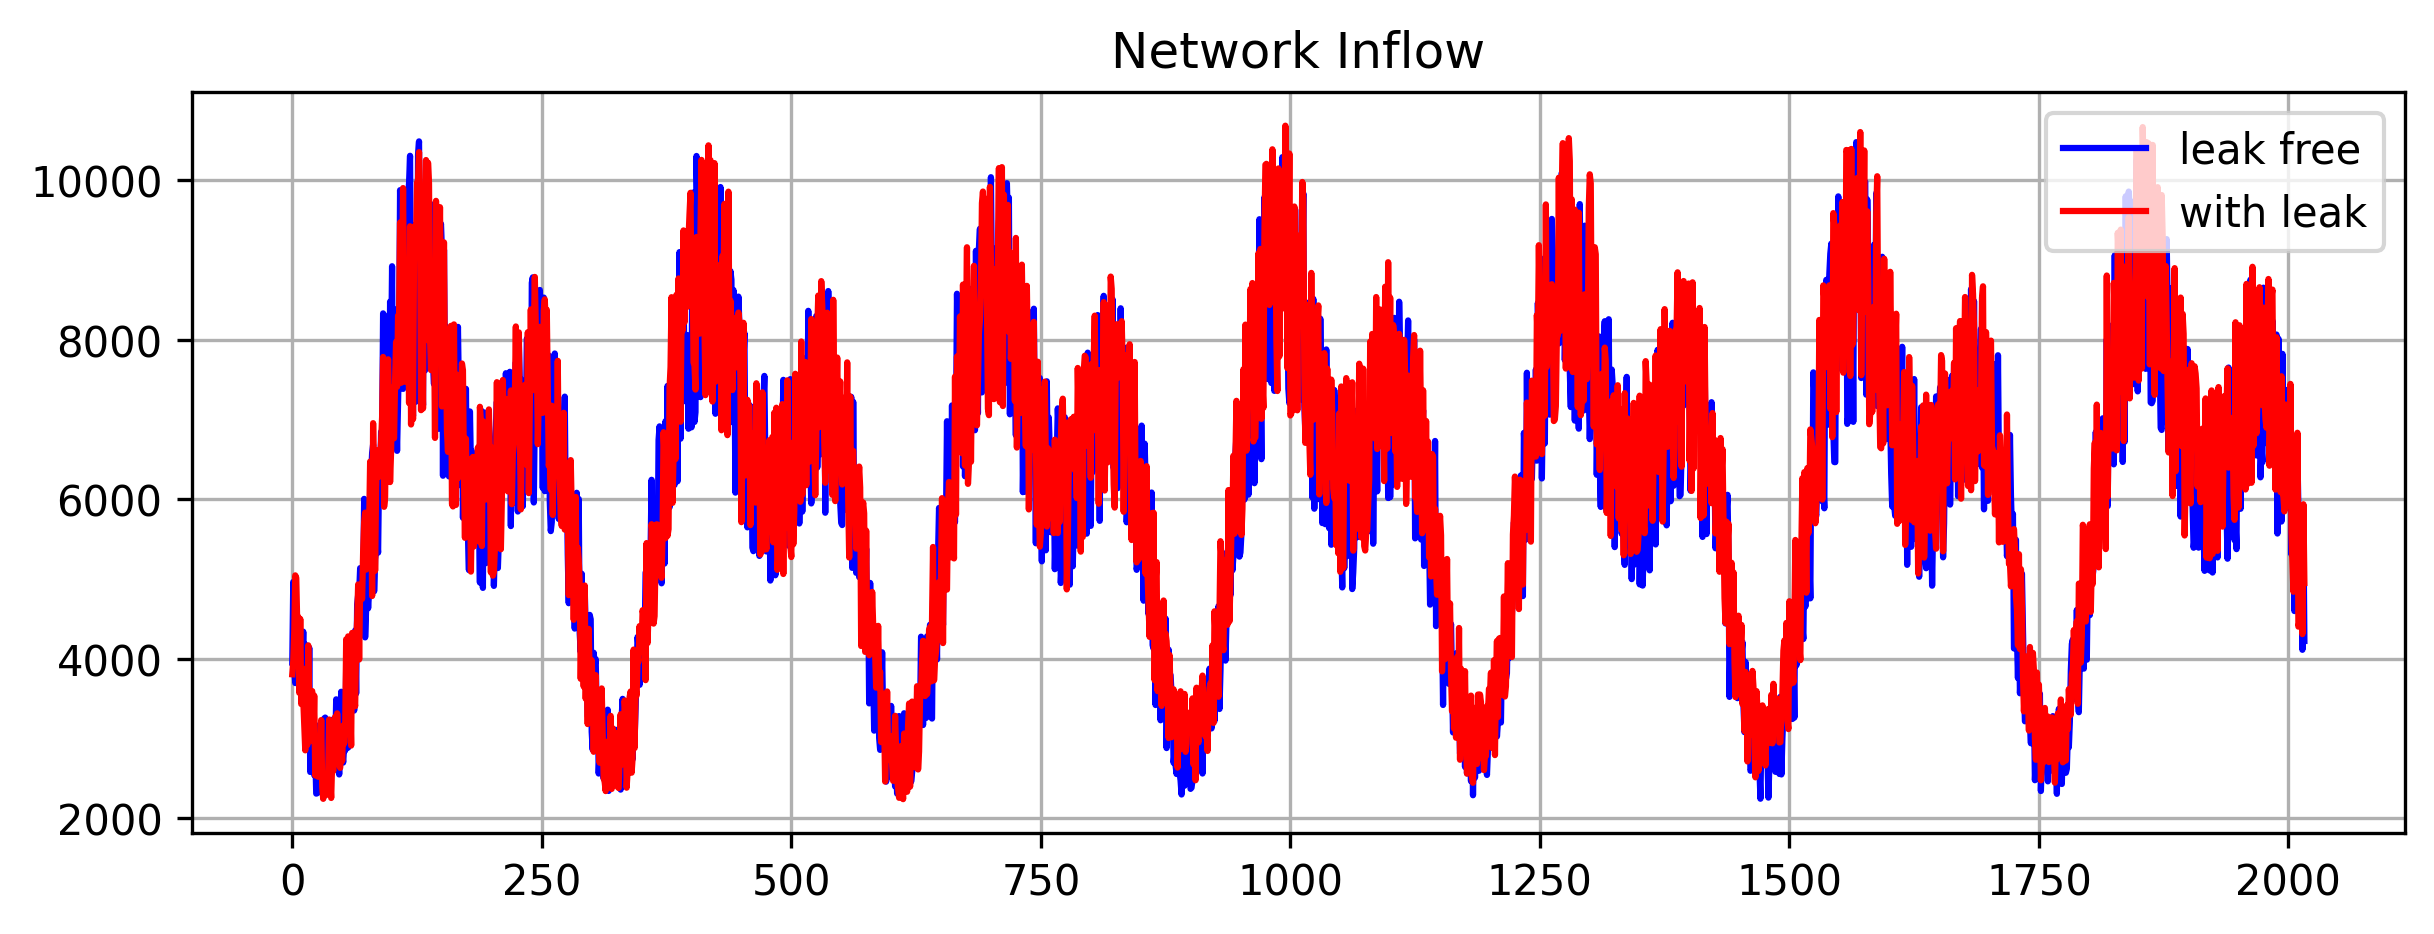

In [20]:
res_ind = d.getNodeReservoirIndex()
res_link = [np.where(d.NodesConnectingLinksIndex[:, 0] == res_ind[i])[0][0] for i in range(len(res_ind))]
Inflow2 = sim_leak.Flow[:, res_link]  # inflow
Inflow2[:3*288] = Inflow1[:3*288]  # change leak start time
eta = np.random.rand(len(Inflow2),1) * np.mean(Inflow1) * 0.0001
y2 = Inflow2 * (1 + eta)  # measured inflow

fig, ax = plt.subplots(figsize=(4, 3))
fig.set_figwidth(8)
plt.plot(y1, color='blue', label='leak free')
plt.grid(True)
plt.plot(y2, color='red', label='with leak')
plt.legend(loc='upper right')
plt.title('Network Inflow')
plt.show()

Plot leakage location:

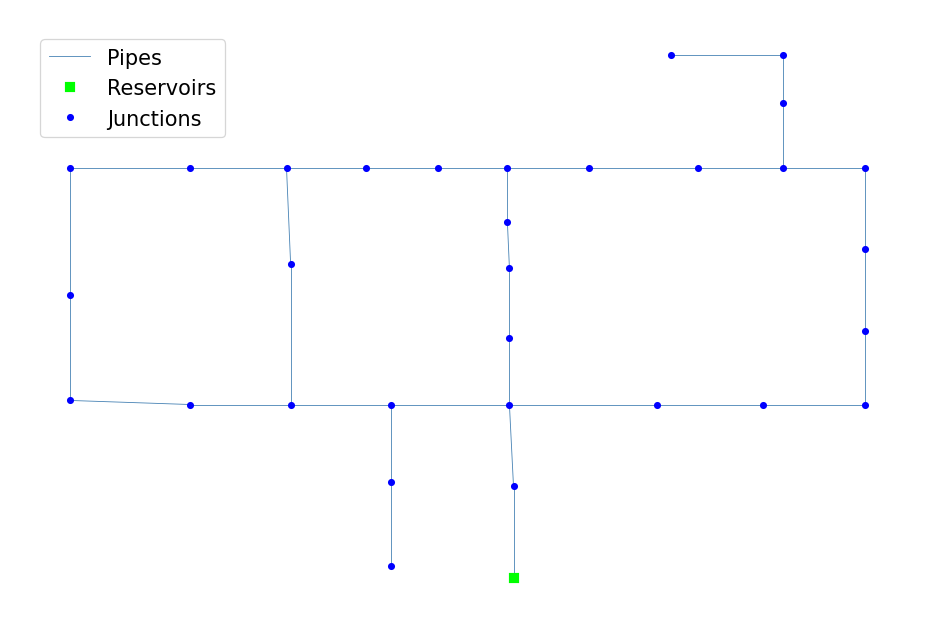

x =  5227.8
y =  6542.06


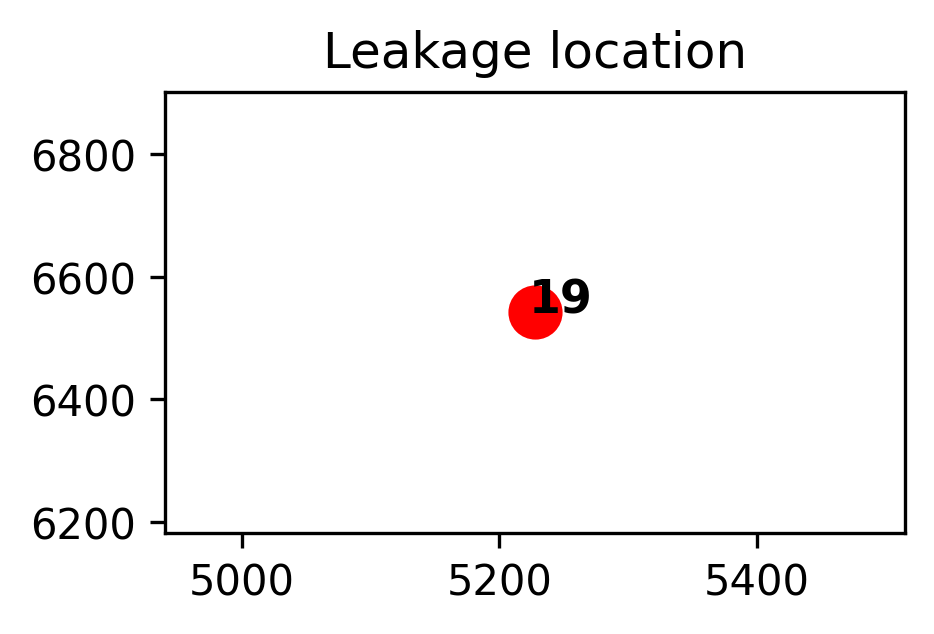

In [21]:
d.plot()
coor = d.getNodeCoordinates()
x = coor['x'][leak_node]
y = coor['y'][leak_node]
print("x = ", x)
print("y = ", y)

plt.plot(x, y, 'o', linewidth=2, markeredgecolor='r', markerfacecolor='r', markersize=12)
plt.text(x - 5, y, d.getNodeNameID()[leak_node-1], color='black', fontweight='bold', fontsize=11)
plt.title('Leakage location')
plt.show()

## Leakage Detection
#### Minimum Night Flow Analysis
![Alt text](images/img3.png)
- Basic idea is that each night the uncertainty is low
- Demand is low
- Pressure is high
- Easier to detect leakages

In [22]:
# compute the minimum flow for each day
Y = np.reshape(y2[1:], (288, 7))
print('Y = ', Y.shape)
print(Y)

Y =  (288, 7)
[[3970.75242092 4336.03615725 5043.84772938 ... 4420.02209622
  4524.08423113 3570.58653161]
 [4497.56513275 3429.3230972  3572.13099704 ... 3183.65784851
  2848.75757568 3877.65783375]
 [2914.40508736 4165.84228654 3477.58915904 ... 3559.81906374
  3592.09240232 2959.11512793]
 ...
 [5845.95832607 7187.23077611 5964.08378972 ... 6113.27865979
  6029.38837009 7445.52633835]
 [5596.00345068 5217.1064838  4838.30633722 ... 6741.53422651
  5017.4830643  6832.68332679]
 [4400.58416372 4461.47404279 4535.52709258 ... 4306.48192854
  5935.82969728 4948.04608284]]


In [23]:
MF = np.min(Y, axis=0)
print('MF = ', MF)

MF =  [2456.91848874 2387.8716064  2236.50955404 2251.54922866 2364.51371556
 2253.10475849 2291.71902919]


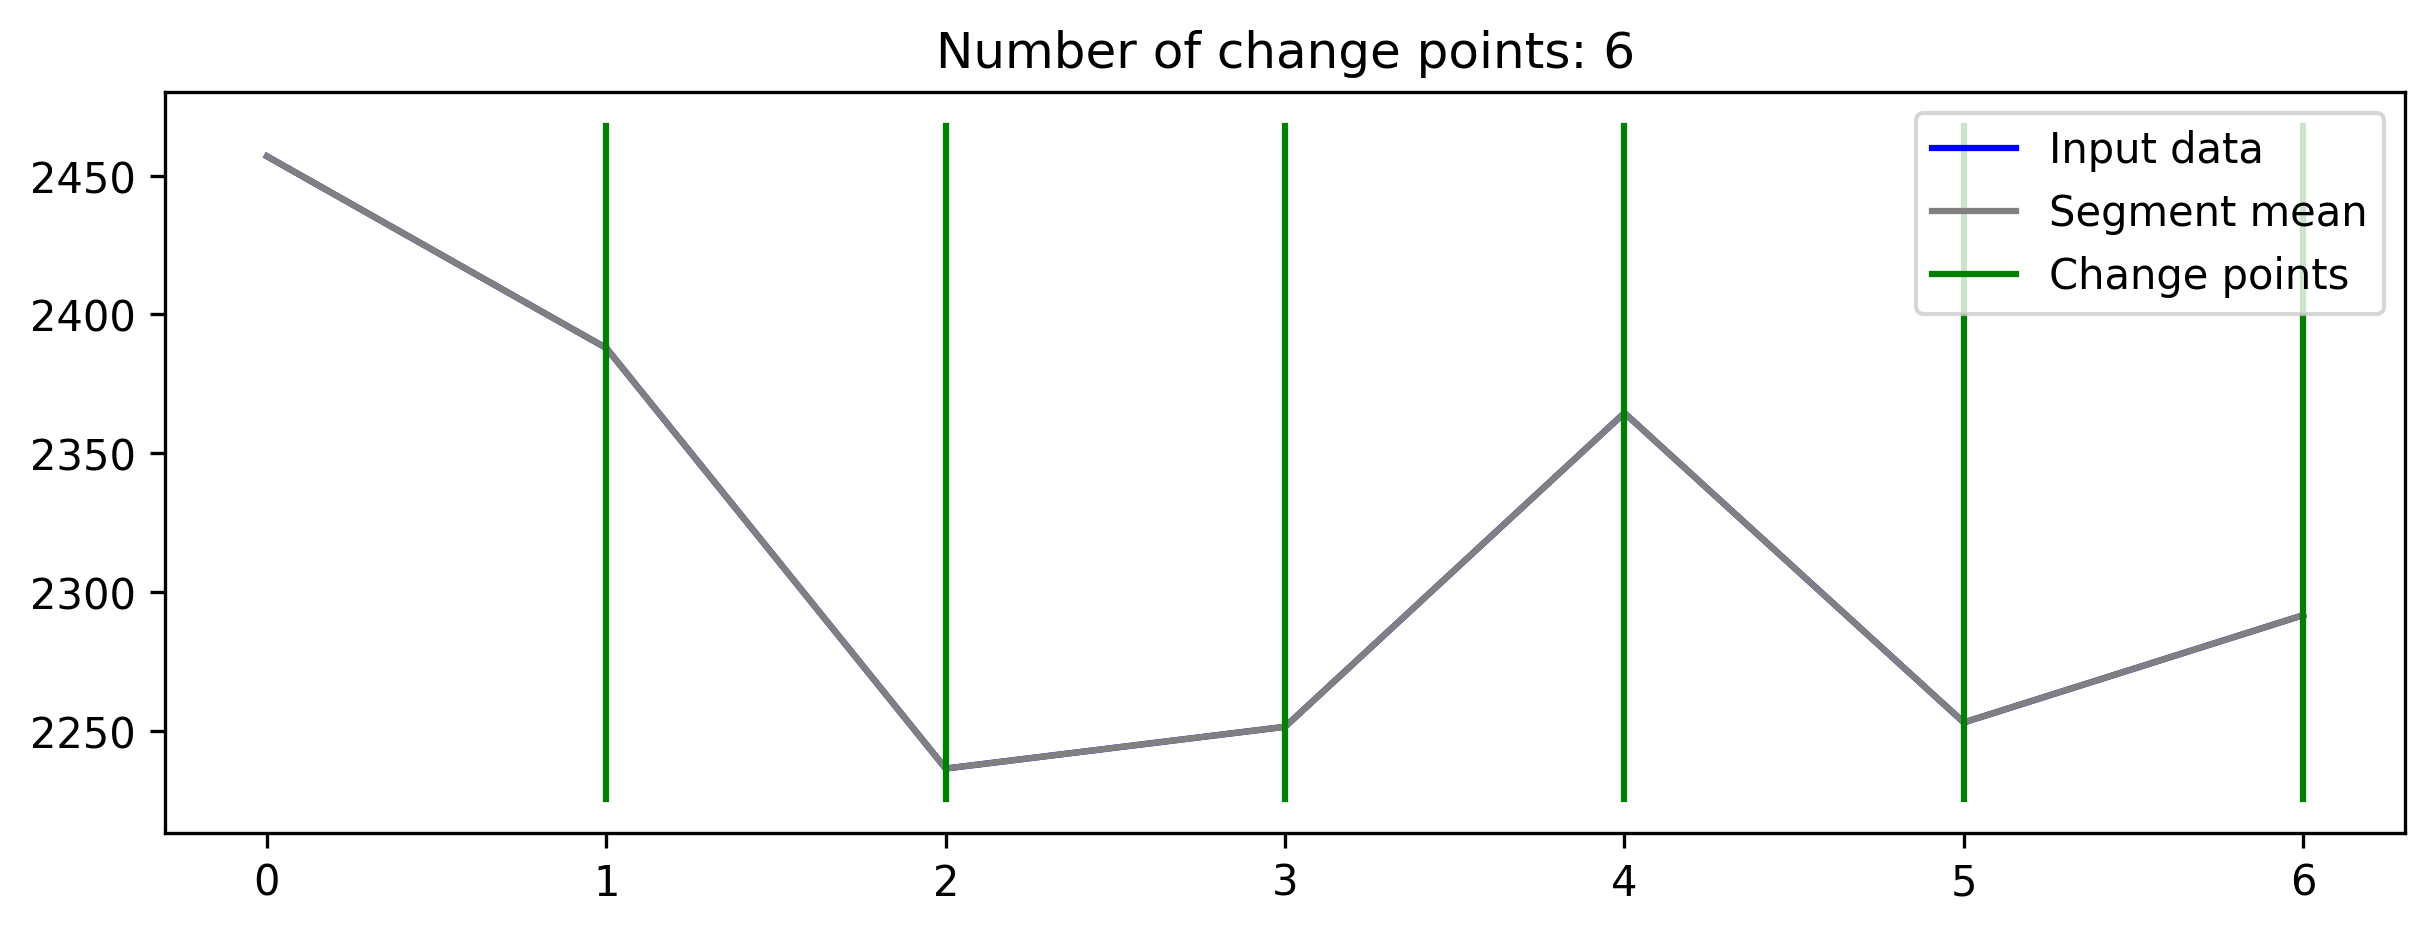

In [24]:
changeIndices = np.zeros(MF.shape, dtype=bool)
segmentMean = MF      
threshold = 3
for i in range(1, len(MF)):
        changeIndices[i] = abs(MF[i] - MF[i-1]) > threshold
  
fig, ax = plt.subplots(figsize=(4, 3))
fig.set_figwidth(8)   
plt.plot(MF, color='blue', label='Input data')
plt.plot(segmentMean, color='grey', label='Segment mean')

indices = np.where(changeIndices)[0]
x = np.repeat(indices, 3)

ymin, ymax = ax.get_ylim()
ylim_nan_column = np.array([ymin, ymax, np.nan])
nnz_changeIndices = np.count_nonzero(changeIndices)
y3 = np.tile(ylim_nan_column, (nnz_changeIndices, 1))
y3 = np.reshape(y3, [len(x), 1])

plt.plot(x, y3, color='green', label='Change points')
plt.title(f'Number of change points: {str(nnz_changeIndices)}')

plt.legend(loc='upper right')

plt.show()

#### Detecting changes
- Change detection algorithms
- Limit checking, change in mean
- Cumulative Sum (CUSUM)

Limit checking, the most simple detection algorithm

In [25]:
threshold = 30
print('threshold = ', threshold)

threshold =  30


In [26]:
alert = MF-MF[0] > threshold
print('alert = ', alert)

alert =  [False False False False False False False]


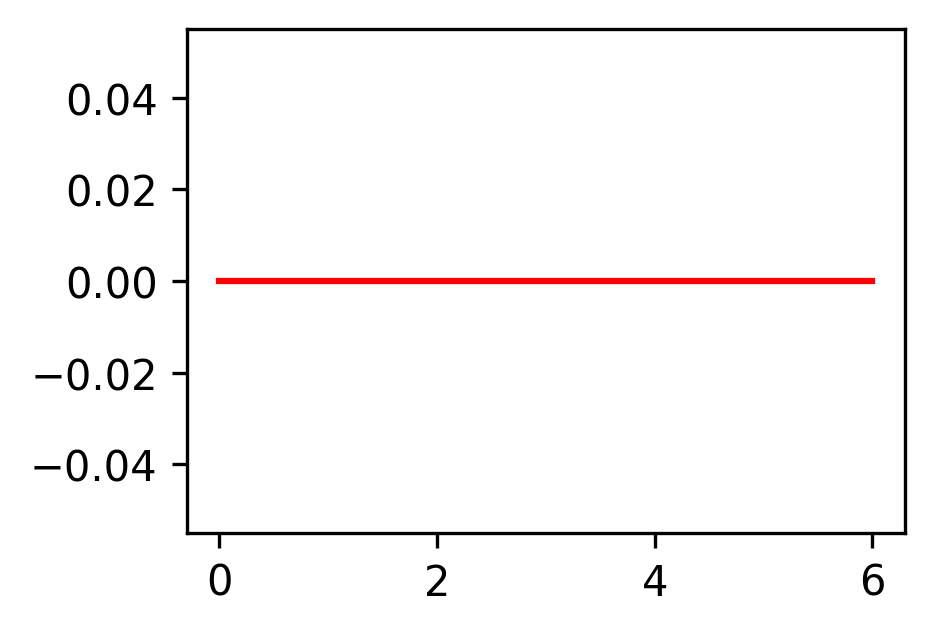

In [27]:
plt.figure()
plt.plot(alert, 'r-')
plt.show()

A different approach would be to take a window of minimum (night) flows, and compare them with the new minimum flow. If it exceeds a precalculated distance, the issue an alert.